In [1]:
!pip install opendatasets --quiet

import opendatasets as od

od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Skipping, found downloaded files in "./animal-faces" (use force=True to force download)


In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

In [3]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
print("Device avaialable: ", device)

Device avaialable:  cpu


In [4]:
image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])

print(data_df["labels"].unique())
data_df.head()

['cat' 'dog' 'wild']


,image_path,labels
0,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
1,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
2,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
3,/content/animal-faces/afhq/train/cat/flickr_ca...,cat
4,/content/animal-faces/afhq/train/cat/pixabay_c...,cat


In [5]:
train = data_df.sample(frac=0.7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5)
test = test.drop(val.index)

In [6]:
print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


In [7]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"])

transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float)
    ]
)

In [8]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, index):
    img_path = self.dataframe.iloc[index, 0]
    label = self.labels[index]

    image = Image.open(img_path).convert('RGB')

    if self.transform:
      image = self.transform(image).to(device)

    return image, label

In [9]:
train_df = CustomImageDataset(dataframe=train, transform=transform)
val_df = CustomImageDataset(dataframe=val, transform=transform)
test_df = CustomImageDataset(dataframe=test, transform=transform)

In [10]:
train_df.__len__()

11291

In [11]:
train_df.__getitem__(2)

(tensor([[[0.9020, 0.8980, 0.9059,  ..., 0.8510, 0.8431, 0.8392],
          [0.8980, 0.8941, 0.9020,  ..., 0.8627, 0.8627, 0.8588],
          [0.8980, 0.8941, 0.9020,  ..., 0.8784, 0.8784, 0.8784],
          ...,
          [0.9451, 0.9843, 0.9882,  ..., 0.9608, 0.9804, 0.9843],
          [0.9255, 0.9608, 0.9725,  ..., 0.9765, 0.9725, 0.9843],
          [0.8745, 0.9216, 0.9529,  ..., 0.9765, 0.9686, 0.9843]],
 
         [[0.8863, 0.8824, 0.8902,  ..., 0.8431, 0.8353, 0.8314],
          [0.8824, 0.8784, 0.8863,  ..., 0.8549, 0.8549, 0.8510],
          [0.8824, 0.8784, 0.8863,  ..., 0.8706, 0.8706, 0.8706],
          ...,
          [0.7804, 0.8510, 0.8745,  ..., 0.8314, 0.9020, 0.9137],
          [0.7451, 0.8118, 0.8431,  ..., 0.8588, 0.8980, 0.9216],
          [0.6784, 0.7608, 0.8118,  ..., 0.8627, 0.9020, 0.9216]],
 
         [[0.8902, 0.8863, 0.8941,  ..., 0.8941, 0.8863, 0.8824],
          [0.8863, 0.8824, 0.8902,  ..., 0.9059, 0.9059, 0.9020],
          [0.8863, 0.8824, 0.8902,  ...,

In [12]:
label_encoder.inverse_transform([0])

array(['cat'], dtype=object)

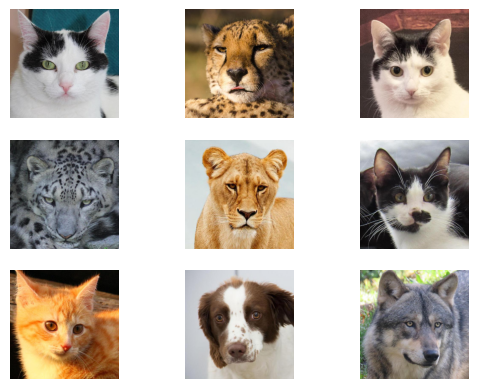

In [13]:
n_rows = 3
n_cols = 3

f,axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n=1)["image_path"].iloc[0])
    axarr[row, col].imshow(image)
    axarr[row, col].axis('off')
plt.show()

In [14]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [15]:
train_loader = DataLoader(train_df, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_df, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_df, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

    self.pooling = nn.MaxPool2d(2, 2)

    self.relu = nn.ReLU()
    self.flatten =nn.Flatten()
    self.linear = nn.Linear((128 * 16 * 16), 128)

    self.output = nn.Linear(128, len(data_df['labels'].unique()))

  def forward(self, x):
    x = self.conv1(x)     # (32, 128, 128)
    x = self.pooling(x)   # (32, 64, 64)
    x = self.relu(x)

    x = self.conv2(x)     # (64, 64, 64)
    x = self.pooling(x)   # (64, 32, 32)
    x = self.relu(x)

    x = self.conv3(x)     # (128, 32, 32)
    x = self.pooling(x)   # (128, 16, 16)
    x = self.relu(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)

    return x

In [21]:
model = Net().to(device)

In [22]:
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=32768, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=3, bias=True)
)

In [23]:
from torchsummary import summary

summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [29]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()

    outputs = model(inputs)

    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()
    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()

    total_acc_train += train_acc

    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)

      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_val_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/train_df.__len__() * 100, 4))
  total_acc_val_plot.append(round(total_acc_val/val_df.__len__(), 4))

  print(
      f"""Epoch: {epoch+1}/{EPOCHS}
      Train Loss: {round(total_loss_train/1000, 4)}| Train Accuracy: {round(total_acc_train/train_df.__len__() * 100, 4)}
      Val Loss: {round(total_loss_val/1000, 4)}\t | Val Accuracy: {round(total_acc_val/val_df.__len__() * 100, 4)}
      """
  )
  print("=" * 100)

Epoch: 1/10
      Train Loss: 0.3224	| Train Accuracy: 81.3303
      Val Loss: 0.0398	 | Val Accuracy: 89.8347
      
Epoch: 2/10
      Train Loss: 0.1312	| Train Accuracy: 93.2867
      Val Loss: 0.0336	 | Val Accuracy: 92.1901
      
Epoch: 3/10
      Train Loss: 0.0866	| Train Accuracy: 95.7843
      Val Loss: 0.0192	 | Val Accuracy: 95.3306
      
Epoch: 4/10
      Train Loss: 0.0552	| Train Accuracy: 97.1925
      Val Loss: 0.0205	 | Val Accuracy: 95.0413
      
Epoch: 5/10
      Train Loss: 0.0402	| Train Accuracy: 98.025
      Val Loss: 0.0165	 | Val Accuracy: 95.5785
      
Epoch: 6/10
      Train Loss: 0.029	| Train Accuracy: 98.6449
      Val Loss: 0.0202	 | Val Accuracy: 95.7025
      
Epoch: 7/10
      Train Loss: 0.0256	| Train Accuracy: 98.6715
      Val Loss: 0.0172	 | Val Accuracy: 96.2397
      
Epoch: 8/10
      Train Loss: 0.0155	| Train Accuracy: 99.3623
      Val Loss: 0.0257	 | Val Accuracy: 94.7107
      
Epoch: 9/10
      Train Loss: 0.0121	| Train Accuracy: 99.

In [1]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
    total_acc_test += acc

    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score: {round(total_acc_test/test_df.__len__() * 100, 4)}")
print(f"Loss Score: {round(total_loss_test/test_df.__len__(), 4)}")

NameError: name 'torch' is not defined

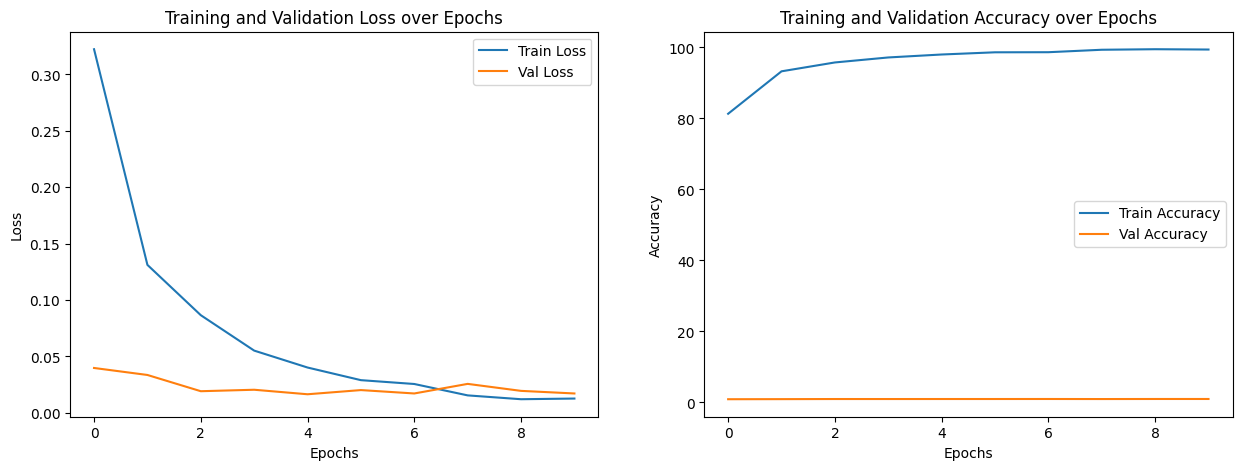

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label="Train Loss")
axs[0].plot(total_loss_val_plot, label="Val Loss")
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(total_acc_train_plot, label="Train Accuracy")
axs[1].plot(total_acc_val_plot, label="Val Accuracy")
axs[1].set_title("Training and Validation Accuracy over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()

In [32]:
# 1 - read image
# 2 - Transform image
# 3 - Predict through model
# 4 - Inverse transform by label encoder

def predict_image(image):
  image = Image.open(image).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))

  output = torch.argmax(output, axis=1).item()
  return label_encoder.inverse_transform(output)

In [33]:
predict_image("/content/img1.jpg")

torch.Size([3, 128, 128])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x256 and 32768x128)